# cMLP Lagged VAR Demo

- In this notebook, we train a cMLP model on linear VAR data with lagged interactions.
- After examining the Granger causality discovery, we train a debiased model using only the discovered interactions.

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_var
from models.cmlp import cMLP, cMLPSparse, train_model_ista, train_unregularized

In [8]:
# For GPU acceleration
device = torch.device('cuda')

In [9]:
import os
root_path = 'datasets/var'

# 遍历文件夹结构
for folder1 in os.listdir(root_path):
    folder1_path = root_path + '/' + folder1
    for folder2 in os.listdir(folder1_path):
        folder2_path = folder1_path + '/' + folder2
        for file in os.listdir(folder2_path):
            if file.endswith('.npz'):
                file_path = folder2_path + '/' + file

                # 读取.npz文件
                data = np.load(file_path)

                # 从文件中提取'X'和'GC'数据
                X_np = data['X']
                GC = data['GC']

                # 将X_np转换为torch tensor
                X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)



# Still need to tune $\lambda$ and perhaps lr

In [10]:
# Set up model
cmlp = cMLP(X.shape[-1], lag=5, hidden=[100]).cuda(device=device)

In [11]:
# Train with ISTA
train_loss_list = train_model_ista(
    cmlp, X, lam=0.002, lam_ridge=1e-2, lr=5e-2, penalty='H', max_iter=50000,
    check_every=100)

----------Iter = 100----------
Loss = 0.147477
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.142586
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.138213
Variable usage = 100.00%
----------Iter = 400----------
Loss = 0.134085
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.130111
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.126250
Variable usage = 100.00%
----------Iter = 700----------
Loss = 0.122480
Variable usage = 100.00%
----------Iter = 800----------
Loss = 0.118786
Variable usage = 100.00%
----------Iter = 900----------
Loss = 0.115160
Variable usage = 100.00%
----------Iter = 1000----------
Loss = 0.111595
Variable usage = 100.00%
----------Iter = 1100----------
Loss = 0.108087
Variable usage = 100.00%
----------Iter = 1200----------
Loss = 0.104635
Variable usage = 100.00%
----------Iter = 1300----------
Loss = 0.101236
Variable usage = 100.00%
----------Iter = 1400----------
Loss = 0.097890
Variable usa

True variable usage = 40.00%
Estimated variable usage = 0.00%
Accuracy = 60.00%


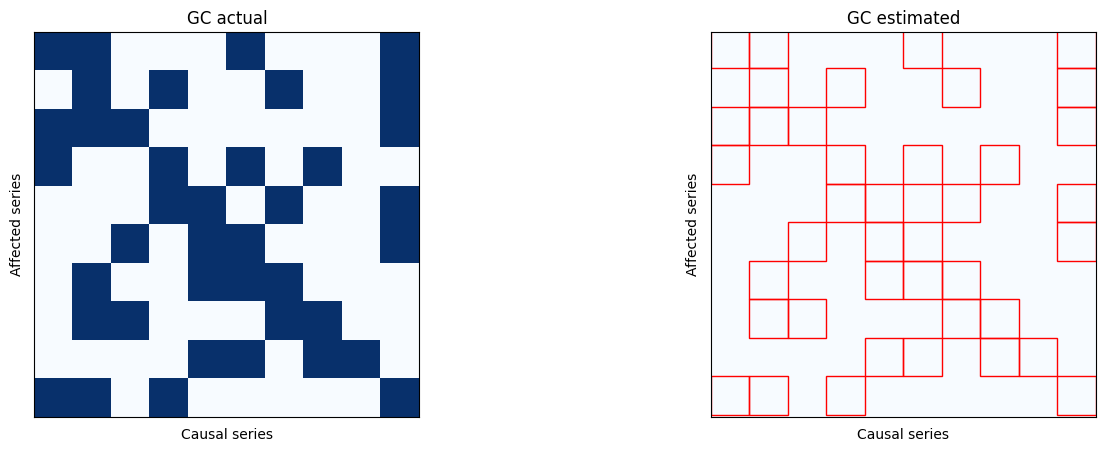

In [12]:
# Verify learned Granger causality
GC_est = cmlp.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()

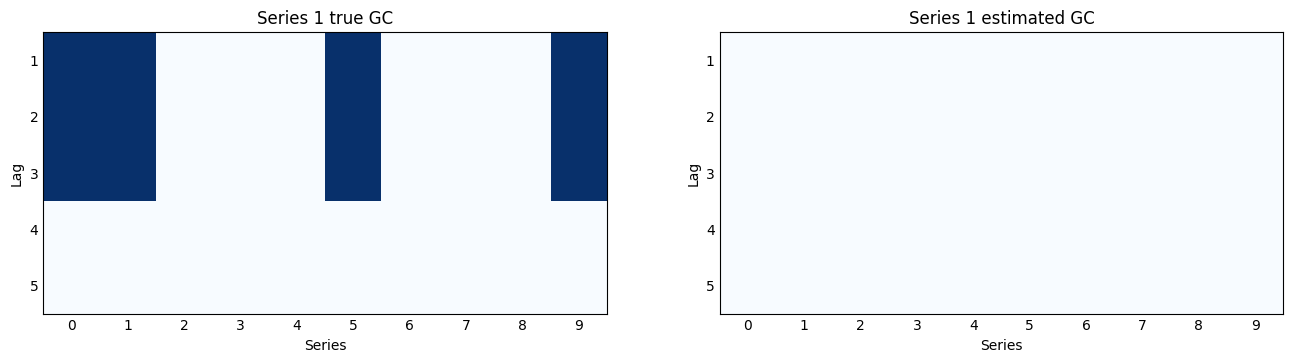

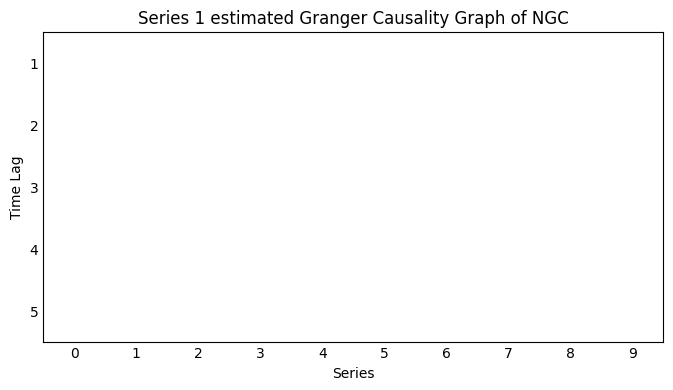

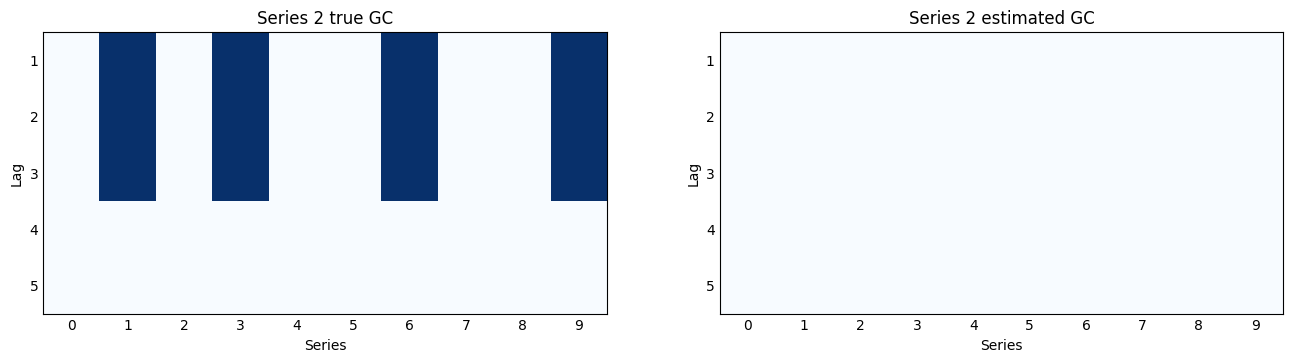

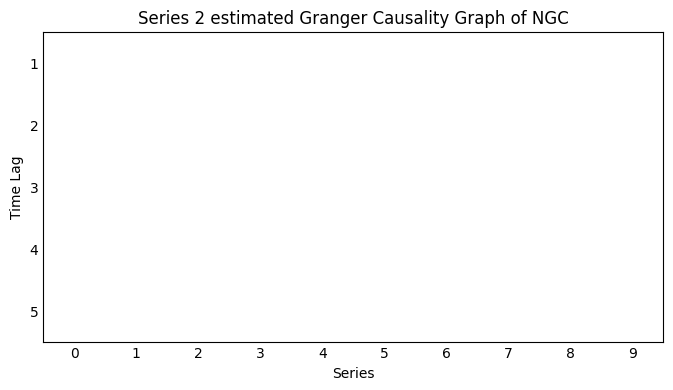

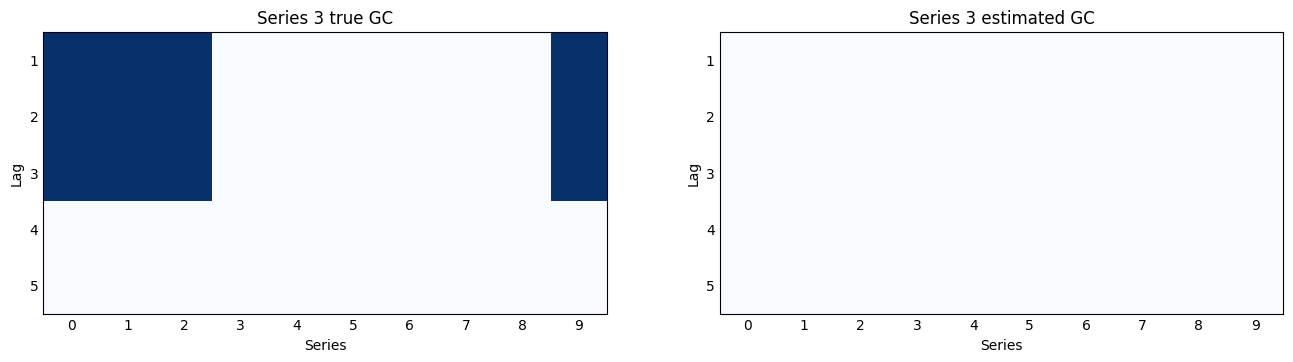

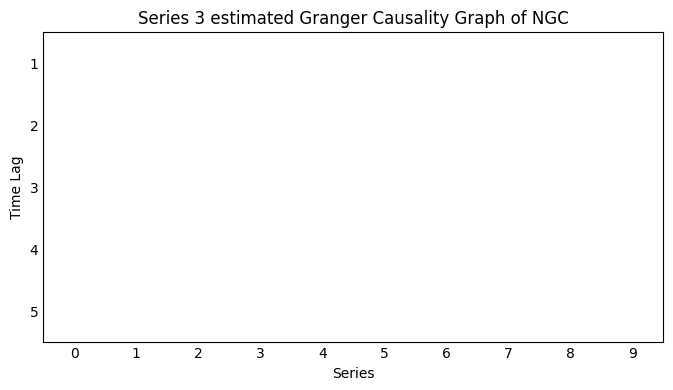

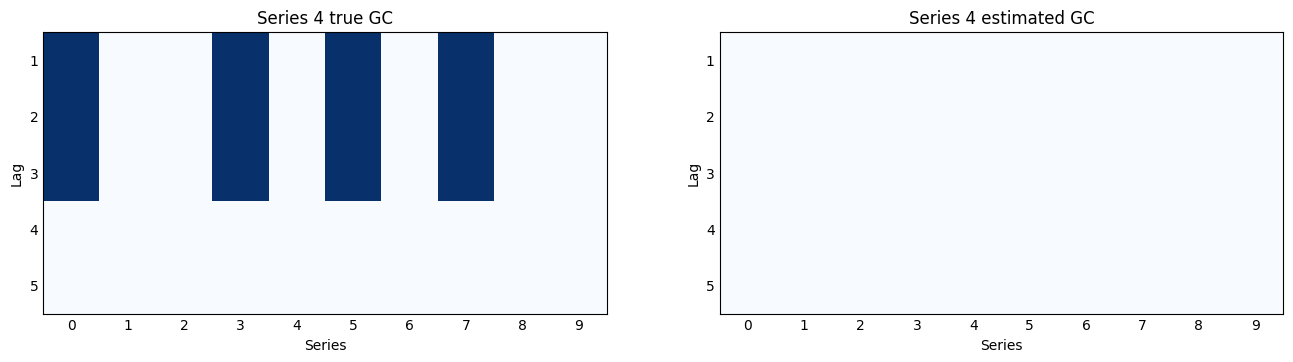

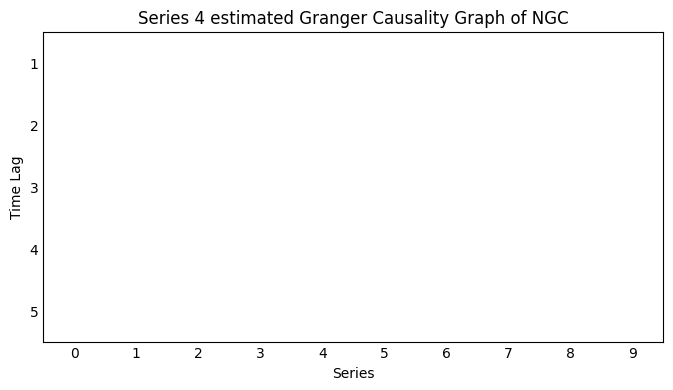

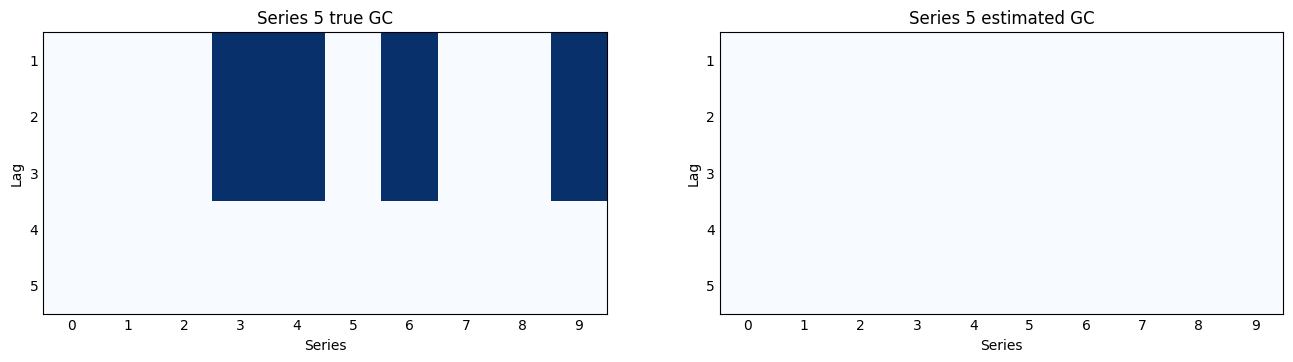

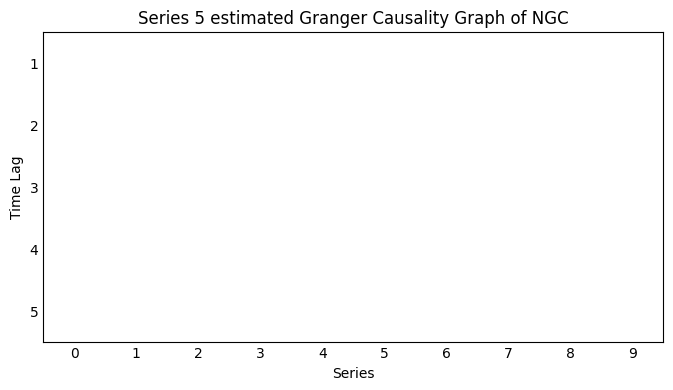

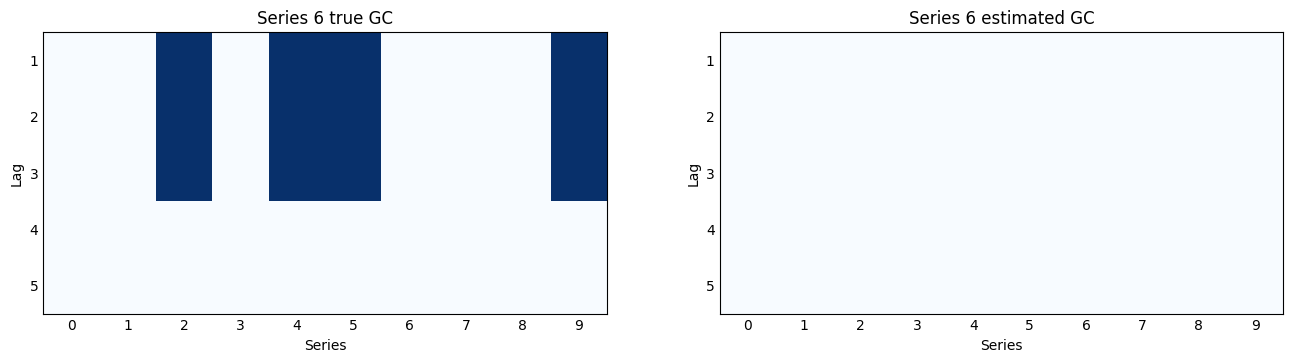

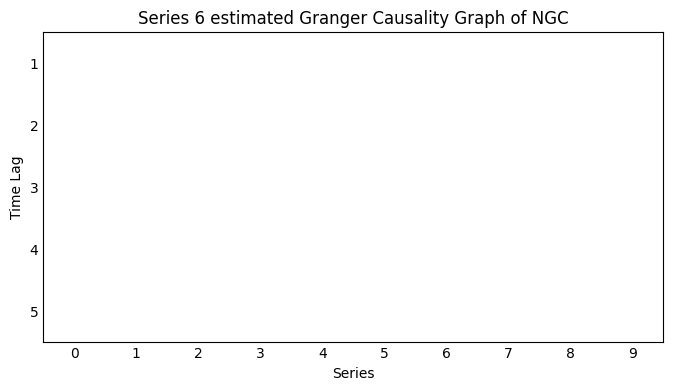

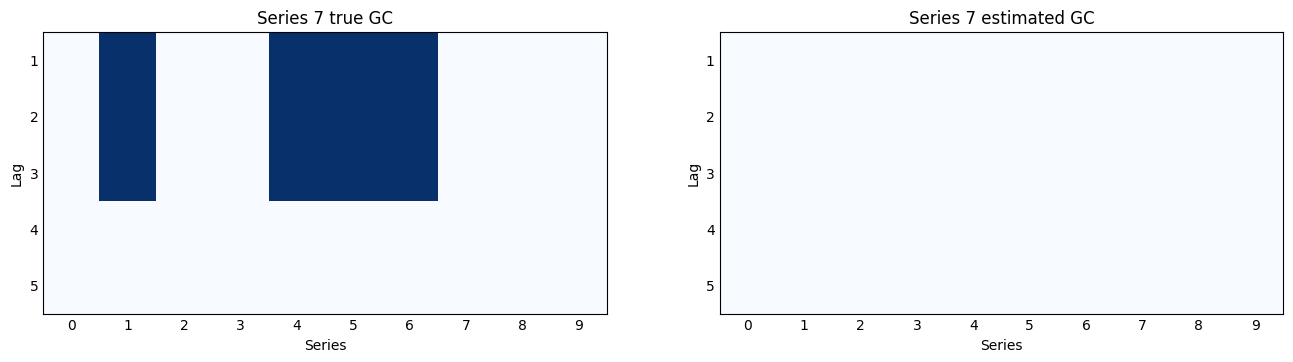

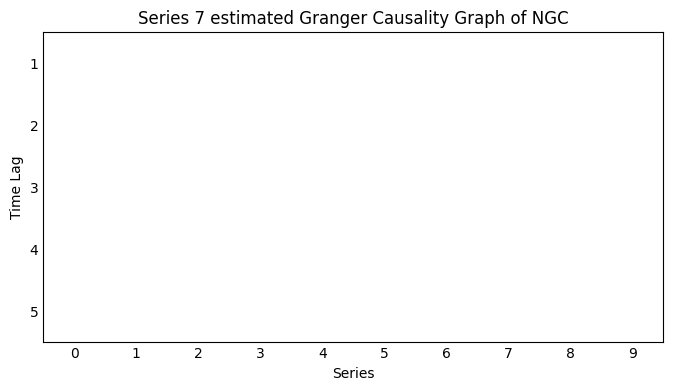

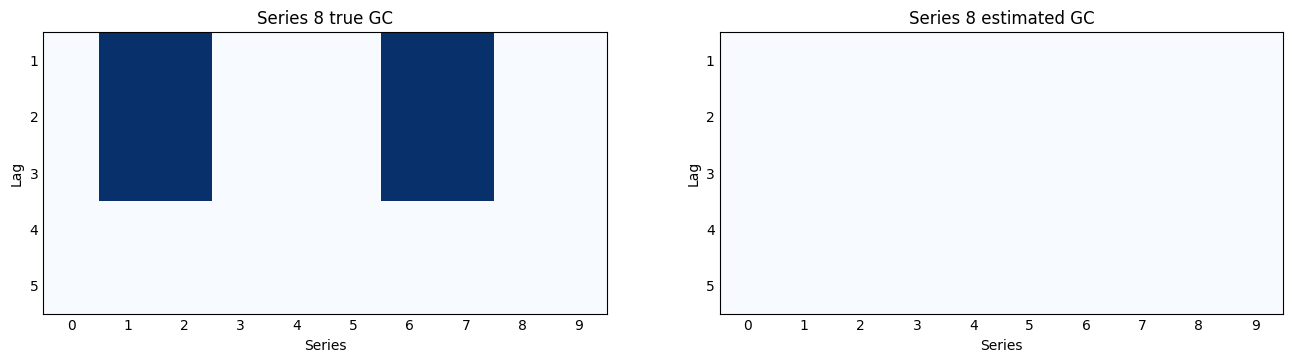

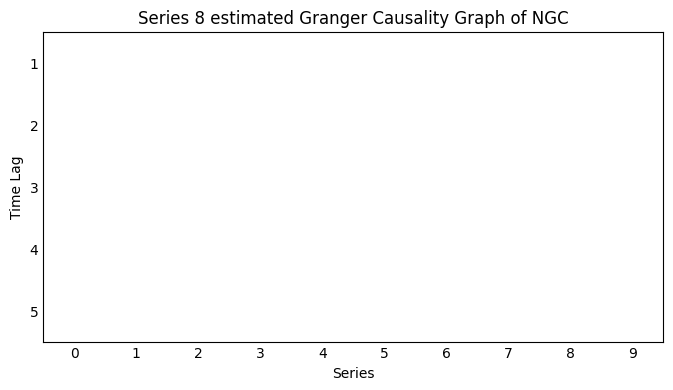

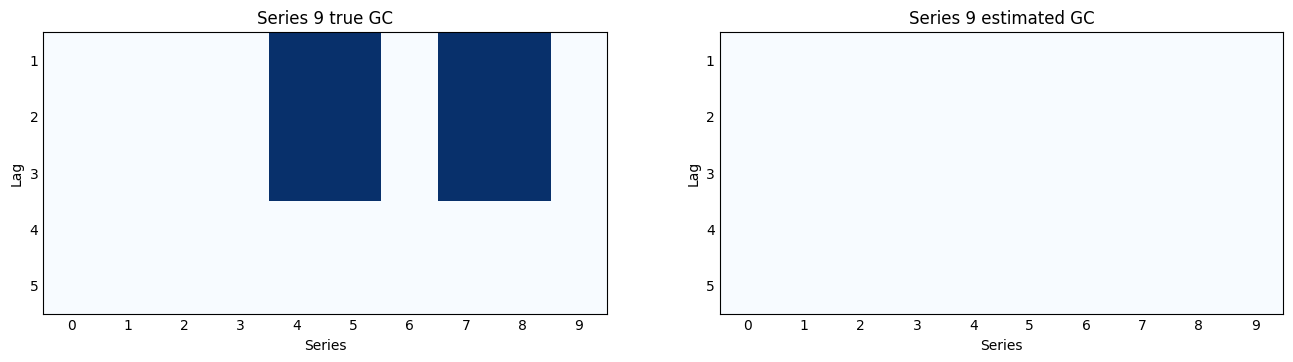

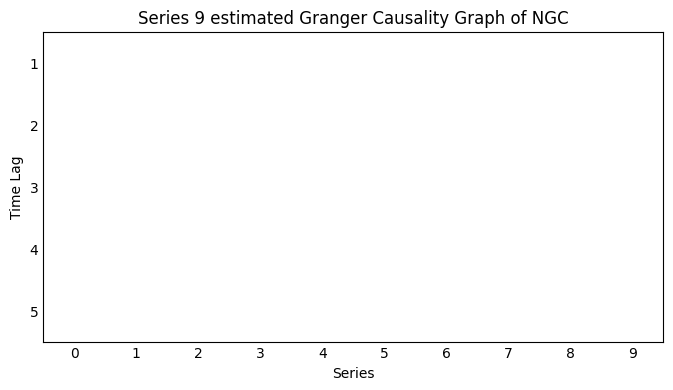

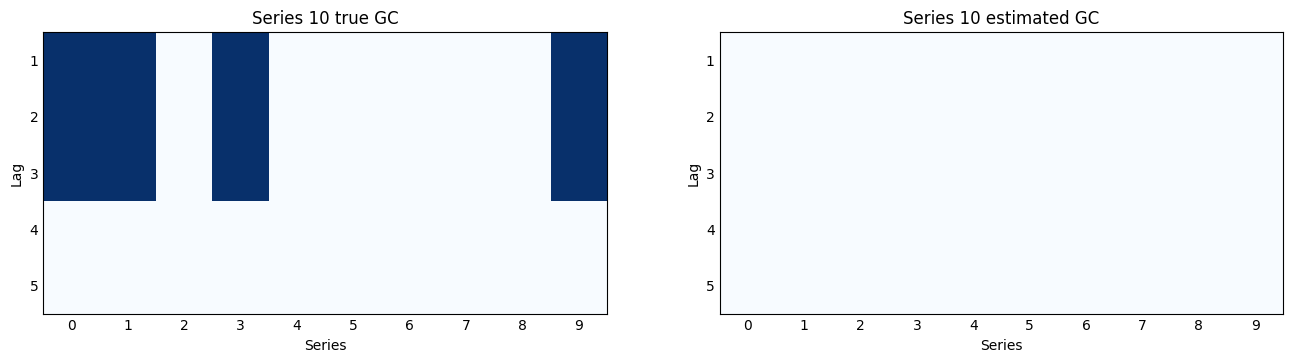

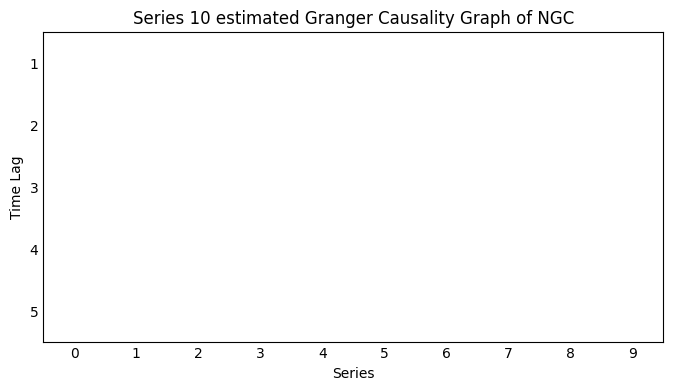

In [13]:
# Verify lag selection
for i in range(len(GC_est)):
    # Get true GC
    GC_lag = np.zeros((5, len(GC_est)))
    GC_lag[:3, GC[i].astype(bool)] = 1.0

    # Get estimated GC
    GC_est_lag = cmlp.GC(ignore_lag=False, threshold=False)[i].cpu().data.numpy().T[::-1]

    # Make figures
    fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
    axarr[0].imshow(GC_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
    axarr[0].set_title('Series %d true GC' % (i + 1))
    axarr[0].set_ylabel('Lag')
    axarr[0].set_xlabel('Series')
    axarr[0].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[0].set_xticklabels(range(len(GC_est)))
    axarr[0].set_yticks(np.arange(5) + 0.5)
    axarr[0].set_yticklabels(range(1, 5 + 1))
    axarr[0].tick_params(axis='both', length=0)

    axarr[1].imshow(GC_est_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
    axarr[1].set_title('Series %d estimated GC' % (i + 1))
    axarr[1].set_ylabel('Lag')
    axarr[1].set_xlabel('Series')
    axarr[1].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[1].set_xticklabels(range(len(GC_est)))
    axarr[1].set_yticks(np.arange(5) + 0.5)
    axarr[1].set_yticklabels(range(1, 5 + 1))
    axarr[1].tick_params(axis='both', length=0)

    # Mark nonzeros
    for k in range(len(GC_est)):
        for j in range(5):
            if GC_est_lag[j, k] > 0.0:
                rect = plt.Rectangle((k, j), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
                axarr[1].add_patch(rect)

    plt.show()

    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    ax.imshow(GC_est_lag, cmap='Greys', extent=(0, len(GC_est), 5, 0))
    ax.set_title('Series %d estimated Granger Causality Graph of NGC' % (i + 1))
    ax.set_ylabel('Time Lag')
    ax.set_xlabel('Series')
    ax.set_xticks(np.arange(len(GC_est)) + 0.5)
    ax.set_xticklabels(range(len(GC_est)))
    ax.set_yticks(np.arange(5) + 0.5)
    ax.set_yticklabels(range(1, 5 + 1))
    ax.tick_params(axis='both', length=0)
    for l in range(len(GC_est)):
        for j in range(5):
            if GC_est_lag[j, l] > 0.0:
                rect = plt.Rectangle((l, j), 1, 1, facecolor='none', edgecolor='red', linewidth=1.0)
                ax.add_patch(rect)
    plt.savefig('./imgs/NGC_ori_var3_0_img{}.tiff'.format(i), dpi=600)

    # 真实因果图
    # plt.figure(figsize=(8, 5))
    # ax = plt.gca()
    # ax.imshow(GC_lag, cmap='Greys', extent=(0, len(GC_est), 5, 0))
    # ax.set_title('Series %d true Granger Causality Graph of VAR(3)' % (i + 1))
    # ax.set_ylabel('Time Lag')
    # ax.set_xlabel('Series')
    # ax.set_xticks(np.arange(len(GC_est)) + 0.5)
    # ax.set_xticklabels(range(len(GC_est)))
    # ax.set_yticks(np.arange(5) + 0.5)
    # ax.set_yticklabels(range(1, 5 + 1))
    # ax.tick_params(axis='both', length=0)
    # plt.savefig('./imgs/NGC_true_var3_0_img{}.tiff'.format(i), dpi=600)
    

# Train sparsified model

In [14]:
# Create a debiased model
sparsity = cmlp.GC().bool()
cmlp_sparse = cMLPSparse(X.shape[-1], sparsity, lag=5, hidden=[100]).cuda(device=device)

# Train
train_loss_list = train_unregularized(cmlp_sparse, X, lr=1e-3, max_iter=10000,
                                      check_every=100, verbose=1)

/root/miniconda3/envs/NGC37/lib/python3.7/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


ZeroDivisionError: float division by zero

In [ ]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.title('Debiased model training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.plot(100 * np.arange(len(train_loss_list)), train_loss_list)
plt.show()

In [ ]:
# Get optimal forecasts using VAR parameters
X_optimal_forecast = np.zeros((X.shape[-1], 1000-3))
for t in range(1000-3):
    X_optimal_forecast[:, t] = np.dot(beta, X_np.T[:, t:(t+3)].flatten(order='F'))
X_optimal_forecast = X_optimal_forecast.T

# Forecast using debiased cMLP
X_pred = cmlp_sparse(X)

# Plot actual data and forecasts
num_points = 25

for i in range(X.shape[-1]):
    plt.figure(figsize=(10, 5))
    plt.plot(X[0, 3:num_points+3, i].cpu().data.numpy(), label='Actual')
    plt.plot(X_pred[0, :num_points, i].cpu().data.numpy(), label='cMLP forecasting')
    plt.plot(X_optimal_forecast[:num_points, i], label='Optimal forecasting')
    plt.legend(loc='upper right')
    plt.title('Series %d forecasting' % (i + 1))
    plt.show()